****The model is built on Kannada MNIST dataset. https://www.kaggle.com/c/Kannada-MNIST/overview 

In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt 
import keras
from keras.layers import ReLU
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


Reading the training and test dataset

In [2]:
# Training data
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
# Test data
test = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
# Dig is Additional Data
dig = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [3]:
# Sample submission for Kaggle
sample_sub = pd.read_csv("/kaggle/input/Kannada-MNIST/sample_submission.csv")

In [4]:
# Training data has 60,000 samples
print("Train data size = " +str(train.shape))
# Test data has 5,000 samples
print("Test data size = " +str(test.shape))
# Dig data has 10240 samples
print("Dig data size = " +str(dig.shape))

Train data size = (60000, 785)
Test data size = (5000, 785)
Dig data size = (10240, 785)


In [5]:
# Training data has 785 colums, in which the first column corresponds to the label and the other 784 column corresponds 
# to the pixel values of 28 X 28 dimension data.
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We slice the dataframes to define the features and the labels

In [6]:
# First column is the label 'Y' and rest of 784 columns are the pixel values. 
X=train.iloc[:,1:].values 
Y=train.iloc[:,0].values 
Y[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
# Reshape the data to make it comply with the keras API.
X = X.reshape(X.shape[0], 28, 28,1) 
print(X.shape)


(60000, 28, 28, 1)


In [8]:
# Convert the data points to categorical(one hot encoded) form.
Y = keras.utils.to_categorical(Y, 10) 
print(Y.shape)

(60000, 10)


In [9]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# id column is not required in test, so it is removed
x_test=test.drop('id', axis=1).iloc[:,:].values
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_test.shape

(5000, 28, 28, 1)

In [11]:
dig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Labels in dig is removed to use this data points to test the accuracy of the model
x_dig=dig.drop('label',axis=1).iloc[:,:].values
print(x_dig.shape)
x_dig = x_dig.reshape(x_dig.shape[0], 28, 28,1)
x_dig.shape

(10240, 784)


(10240, 28, 28, 1)

In [13]:
# Lab of dig can be used to compare the true label with predicted label
y_dig=dig.label
y_dig.shape

(10240,)

We split the data into training and validation set.

In [14]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.08) 

In [15]:
# Data Augmentation is used to artificially increase the size of the dataset by rotating, zooming translating the pixels
# in the image. Care has to be taken that the data augmentation is not conducted at a very huge amount as it can completely
# change the features of the image.
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.1,
                                   zoom_range = 0.25,
                                   horizontal_flip = False)

In [16]:
# In validation set no data augmentation is performed, only the pixel values are converted from 0 to 255 to 0 to 1  
valid_datagen = ImageDataGenerator(rescale=1./255) 

In [17]:
# This is the function for learning rate decay. After every iteration the learning rate is reduced by a small amount.
# This helps the algorithm converge faster to the global minimum.
def lr_decay(epoch):
    return il_rate * 0.99 ** epoch

In [18]:
# A Sequential model is built.
# 6 2d-convolution layers are used. Each has 3 X 3 Filters. 
# The number of depth channels for each Convolution layer are 64, 64, 128, 128, 256, 256.
# The number of depth channels are increased because the later layers have to learn more complex features.
# Batch Normalization is used because it makes the training of the CNN easier. Maxpooling reduces the number of channels which 
# reduces the complexity of the Neural Network as the less important features are removed which also improves the accuracy.
# Dropout forces the layer to learn the deatures using fewer number of neurons which helps deal with overfitting.
# Momentum makes the optimization rate faster.

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

In [19]:
il_rate=2e-3
batch_size = 1024
epochs = 30
input_shape = (28, 28, 1)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

In [20]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=il_rate),
              metrics=['accuracy'])

In [21]:
history = model.fit_generator(
      train_datagen.flow(X_train,Y_train, batch_size=batch_size),
      epochs=epochs,
      callbacks=[LearningRateScheduler(lr_decay), early_stopping],
      validation_data=valid_datagen.flow(X_valid,Y_valid), 
      verbose=2)

Epoch 1/30
54/54 - 21s - loss: 0.8126 - acc: 0.7231 - val_loss: 1.2371 - val_acc: 0.8625
Epoch 2/30
54/54 - 16s - loss: 0.1472 - acc: 0.9544 - val_loss: 0.5499 - val_acc: 0.9002
Epoch 3/30
54/54 - 16s - loss: 0.0909 - acc: 0.9707 - val_loss: 0.2005 - val_acc: 0.9898
Epoch 4/30
54/54 - 17s - loss: 0.0712 - acc: 0.9766 - val_loss: 0.0569 - val_acc: 0.9917
Epoch 5/30
54/54 - 16s - loss: 0.0580 - acc: 0.9811 - val_loss: 0.0459 - val_acc: 0.9879
Epoch 6/30
54/54 - 16s - loss: 0.0482 - acc: 0.9845 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 7/30
54/54 - 16s - loss: 0.0494 - acc: 0.9838 - val_loss: 0.0299 - val_acc: 0.9919
Epoch 8/30
54/54 - 16s - loss: 0.0430 - acc: 0.9855 - val_loss: 0.0353 - val_acc: 0.9890
Epoch 9/30
54/54 - 16s - loss: 0.0387 - acc: 0.9873 - val_loss: 0.0285 - val_acc: 0.9933
Epoch 10/30
54/54 - 16s - loss: 0.0387 - acc: 0.9874 - val_loss: 0.0163 - val_acc: 0.9967
Epoch 11/30
54/54 - 16s - loss: 0.0367 - acc: 0.9880 - val_loss: 0.0118 - val_acc: 0.9954
Epoch 12/30
54/54 -

In [22]:
preds_dig=model.predict_classes(x_dig/255)
metrics.accuracy_score(preds_dig, y_dig)

0.88603515625

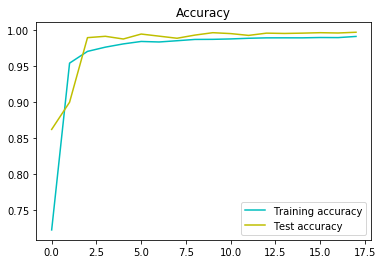

In [27]:
train_acc = history.history['acc']
train_loss = history.history['loss']
validation_acc = history.history['val_acc']
validation_loss = history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'c', label='Training accuracy')
plt.plot(epochs, validation_acc, 'y', label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

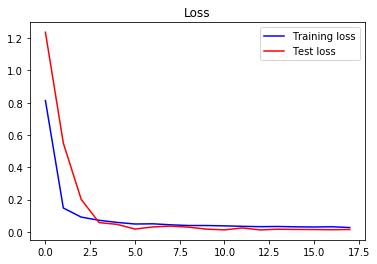

In [26]:
plt.figure()
plt.plot(epochs, train_loss, 'c', label='Training loss')
plt.plot(epochs, validation_loss, 'y', label='Test loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
submission_predict = model.predict_classes(x_test/255.)

In [ ]:
sample_submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')

In [ ]:
sample_submission['label'] = submission_predict

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv("submission.csv",index=False)